In [1]:
import os
import uuid
import zipfile
from os.path import join, dirname
from tempfile import gettempdir
from unittest import TestCase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aequilibrae import TrafficAssignment, TrafficClass, Graph, Project, ODME

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up data:
proj_path = "../../data/chicago_sketch"

In [3]:
# Initialise project:
project = Project()
project.open(proj_path)
project.network.build_graphs()
car_graph = project.network.graphs["c"]  # type: Graph

car_graph.set_graph("free_flow_time")
car_graph.set_blocked_centroid_flows(False)
matrix = project.matrices.get_matrix("demand_omx")
matrix.computational_view()

In [4]:
# Extra data specific to ODME:
index = car_graph.nodes_to_indices
dims = matrix.matrix_view.shape
count_vol_cols = ["class", "link_id", "direction", "obs_volume"]

In [5]:
 # Initial assignment parameters:
assignment = TrafficAssignment()
assignclass = TrafficClass("car", car_graph, matrix)
assignment.set_classes([assignclass])
assignment.set_vdf("BPR")
assignment.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
assignment.set_vdf_parameters({"alpha": "b", "beta": "power"})
assignment.set_capacity_field("capacity")
assignment.set_time_field("free_flow_time")
assignment.max_iter = 5
assignment.set_algorithm("msa")

In [7]:
# Get original flows:.
assignment.execute()
assign_df = assignment.results().reset_index(drop=False).fillna(0)
# SQUISH EXTRA DIMENSION FOR NOW - DEAL WITH THIS PROPERLY LATER ON!!!
matrix.matrix_view = np.squeeze(matrix.matrix_view, axis=2)

# Set the observed count volumes:
flow = lambda i: assign_df.loc[assign_df["link_id"] == i, "matrix_ab"].values[0]
#links = [1, 20, 30, 40, 60, 70]
links = [i for i in range(1, len(assign_df), 500)]
data=[["car", link, 1, flow(link)] for link in links]
count_volumes = pd.DataFrame(
    data=data,
    columns=count_vol_cols
)

# Store original matrix
original_demand = np.copy(matrix.matrix_view)

# Perturb original matrix:
np.random.seed(0)
perturbation = 0.3
perturbation_matrix = np.random.uniform(1 - perturbation/100, 1 + perturbation/100, size=dims)
new_matrix = np.round(matrix.matrix_view * perturbation_matrix)

In [ ]:
# Perform ODME with Spiess:
matrix.matrix_view = np.copy(new_matrix)

spiess = ODME(
    assignment,
    count_volumes,
    stop_crit=(25, 80, 0.001, 0.001),
    algorithm="spiess",
    verbose=True
    )
spiess.execute()

Outer iteration 1 is complete.


Error: Canceled future for execute_request message before replies were done

In [ ]:
spiess_stats = spiess.get_all_statistics()
total_iter_outers_spiess = spiess_stats[spiess_stats["Inner Loop #"] == 0]["Total Iteration #"]

ValueError: No objects to concatenate

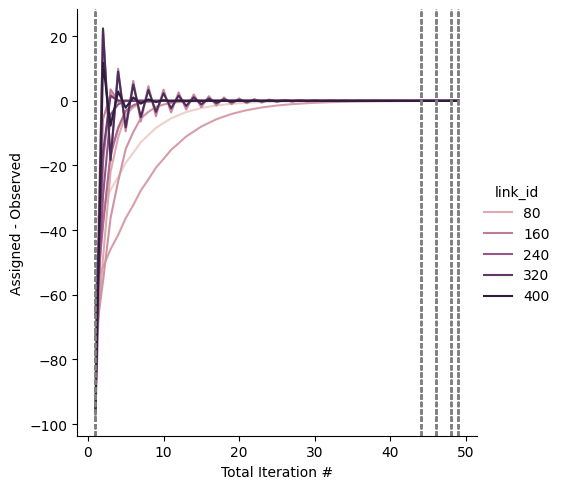

In [ ]:
# Plotting all count volumes:

sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=spiess_stats, 
    markers=True, 
    dashes=False)

for i in total_iter_outers_spiess:
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)